In [116]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

In [117]:
from bokeh.io import output_notebook, show # legend
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
output_notebook()
import plotly
plotly.tools.set_credentials_file(username='czhu505', api_key='asIEqTlAQJOnVrNOGPpE')

Loading BokehJS ...

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from here. Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [68]:
bk = pd.read_csv('BK_18v1.csv',low_memory=False)
bx = pd.read_csv('BX_18v1.csv',low_memory=False)
mn = pd.read_csv('MN_18v1.csv',low_memory=False)
qn = pd.read_csv('QN_18v1.csv',low_memory=False)
si = pd.read_csv('SI_18v1.csv',low_memory=False)

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True,sort=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

In [55]:
ny.describe()

,APPBBL,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgDepth,BldgFront,Block,BoroCode,...,YearAlter1,YearAlter2,YearBuilt,ZipCode,lon,lat,stories,AssessStruct,AssessLand3tile,AssessStruct3tile
count,8.111340e+05,811134.000000,8.111340e+05,8.111340e+05,8.111340e+05,8.111340e+05,811134.000000,811134.000000,811134.000000,811134.000000,...,811134.000000,811134.000000,811134.000000,811130.000000,811134.000000,811134.000000,811134.00000,8.111340e+05,811134.000000,811134.000000
mean,3.813477e+08,2.007968,9.481644e+04,4.477940e+05,3.515303e+09,6.547904e+03,48.583482,27.058638,5320.438081,3.462099,...,216.503245,34.628175,1940.941172,11019.014735,-76.429181,40.301042,0.11225,3.529776e+05,2.010018,2.010080
std,1.199221e+09,0.176181,3.854979e+06,9.828122e+06,1.021924e+09,5.275474e+04,35.836831,33.750576,3673.902181,1.013953,...,621.242901,261.268860,29.114132,467.854799,0.034912,0.025927,1.51961,6.470891e+06,0.818470,0.818453
min,0.000000e+00,2.000000,0.000000e+00,0.000000e+00,1.000020e+09,0.000000e+00,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1851.000000,10001.000000,-76.528905,40.239419,0.00000,0.000000e+00,1.000000,1.000000
25%,0.000000e+00,2.000000,6.986000e+03,2.423100e+04,3.032870e+09,1.453000e+03,35.000000,18.000000,2338.000000,3.000000,...,0.000000,0.000000,1920.000000,10466.000000,-76.447212,40.280921,0.00000,1.552200e+04,1.000000,1.000000
50%,0.000000e+00,2.000000,9.656000e+03,3.151800e+04,4.008600e+09,2.060000e+03,44.000000,20.000000,4863.000000,4.000000,...,0.000000,0.000000,1931.000000,11222.000000,-76.426652,40.299464,0.00000,2.188250e+04,2.000000,2.000000
75%,0.000000e+00,2.000000,1.428800e+04,4.740500e+04,4.104820e+09,3.060000e+03,54.000000,25.000000,7494.250000,4.000000,...,0.000000,0.000000,1960.000000,11370.000000,-76.404557,40.317659,0.00000,3.391875e+04,3.000000,3.000000
max,5.080480e+09,7.000000,3.211276e+09,6.957915e+09,5.080500e+09,1.709504e+07,9388.000000,8050.000000,16350.000000,5.000000,...,2017.000000,2017.000000,2018.000000,12345.000000,-76.363165,40.368737,50.00000,3.746639e+09,3.000000,3.000000


I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [79]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [80]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~czhu505/0 or inside your plot.ly account where it is named 'ny-year-built'


Something looks off... You're going to have to deal with this imperfect data to answer this first question.

### notes on pandas

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

Hello all, here are some pandas tips to help you guys through this homework:

Indexing and Selecting: .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

Group By: This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a reset_index().

Reset_index: I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a huge section on datetime indexing. In particular, check out resample, which provides time series specific aggregation.

Merging, joining, and concatenation: There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Answer

1. Observe the metadata dictionary:

YearBuilt:
Year Built comes from Department of Buildings Permits.
Year Built is accurate for the decade but not necessarily for the specific year.
Two outliers – 1910 & 1920. Structures built between 1800s and early 1900s usually have a Year Built date of either 1910 or 1920.


BBL: BOROUGH, TAX BLOCK & LOT
A concatenation of the borough code, tax block and tax lot.
This field consists of the borough code followed by the tax block followed by the tax lot. The borough code is one numeric digit. The tax block is one to five numeric digits, preceded with leading zeros when the block is less than five digits. The tax lot is one to four digits and is preceded with leading zeros when the lot is less than four digits.
Examples:
Manhattan Borough Code 1, Tax Block 16, Tax Lot 100 would be stored as 1000160100.
Brooklyn Borough Code 3, Tax Block 15828, Tax Lot 7501 would be stored as 5158287501.


NumFloors:
In the tallest building on the tax lot, the number of full and partial stories starting from the ground floor.
This field contains one to five numeric digits with an embedded decimal after the third digit.
NOTES: Above ground Basements are not included in the Number of Floors.
A roof used for parking, farming, playground, etc. is not included in Number of Floors.
If the NUMBER OF FLOORS is zero and the NUMBER OF BUILDINGS is greater than zero, then NUMBER OF FLOORS is not available for the tax lot.
If the NUMBER OF FLOORS is zero and the NUMBER OF BUILDINGS is zero, then NUMBER OF FLOORS is not applicable for the tax lot.

2. To find bin buildings and categorize dataset by every-10-story buildings:
use .resample() function to sum up 5 years number of lots been built.

In [81]:
ny['YearBuiltDatetime'] = pd.to_datetime(ny['YearBuilt'], format = '%Y')
ny_groupByYear = ny.groupby('YearBuiltDatetime').count()['BBL']

trace = go.Scatter(
    x = ny_groupByYear.resample('5A').sum().index,
    y = ny_groupByYear.resample('5A').sum()
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built-5bin')

In [82]:
trace = go.Scatter(
    x = ny_groupByYear.cumsum().index,
    y = 100*ny_groupByYear.cumsum() / ny_groupByYear.sum()
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built', range = [datetime.datetime(1899,1,1), datetime.datetime(2017,1,1)]),
    yaxis = dict(title = 'Cumulative Percentage Built', ticksuffix = '%')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'cumsum-ny')

In [83]:
ny['stories'] = 10*np.floor(ny['NumFloors']/10).apply(int)
ny['stories'] = ny['stories'].apply(lambda x: x if x <= 50 else 50)
ny_storiesAndYear = ny.groupby(['stories', 'YearBuiltDatetime'])['BBL'].count()

In [84]:
traces = []
for group in ny_storiesAndYear.index.levels[0]:
    traces.append(
        go.Scatter(
            name = str(group) + ' Stories',
            x = ny_storiesAndYear[group].index,
            y = 100*ny_storiesAndYear[group].cumsum() / ny_storiesAndYear[group].sum()
        )
    )

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Cumulative Percentage Built')
)

fig = tools.make_subplots(rows=6, cols=1, shared_xaxes=True)

for row,trace in enumerate(traces):
    fig.append_trace(trace, row+1, 1)

fig['layout'].update(height = 900)
for axis in ['yaxis1', 'yaxis2', 'yaxis3', 'yaxis4', 'yaxis5', 'yaxis6']:
    fig['layout'][axis].update(ticksuffix = '%')
fig['layout']['xaxis1'].update(range = [datetime.datetime(1899,1,1), datetime.datetime(2017,1,1)])

py.iplot(fig, filename = 'cumsum-ny-grouped')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]
[ (5,1) x1,y5 ]
[ (6,1) x1,y6 ]



The result shows 1920s had a lot 0-10 story construction been built than others periods. As the time past, there are lesser land for construstion and culture of a modern city change, so that tall building become more demand. If I looked throught the cultivate percentage build, the growth of the number of floors is slowing down. It could be limitted lands affected the speed of growth. 

And the dataset, I have checked some error entry where the address recored a 119-story building and actually only a 3-story building. The acuracy of the data entry will be another problem leading the baise result. 

BK 
cell A82438  : numfloor: 119 ??  address: 100 JEFFERSON STREET 


## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [91]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')


This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook Plotting Perils.

Here is what the same plot would look like in datashader:

C:\Users\Zhu\Anaconda3\lib\site-packages\datashader\transfer_functions.py:162: RuntimeWarning:

invalid value encountered in log1p



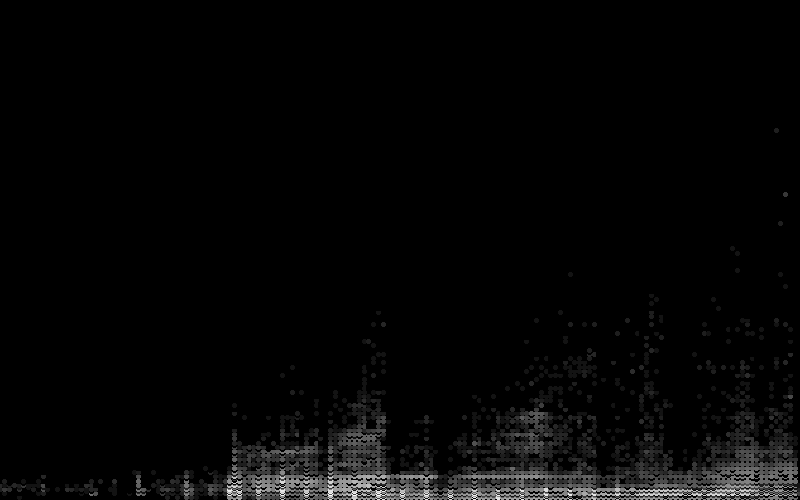

In [93]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')


That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

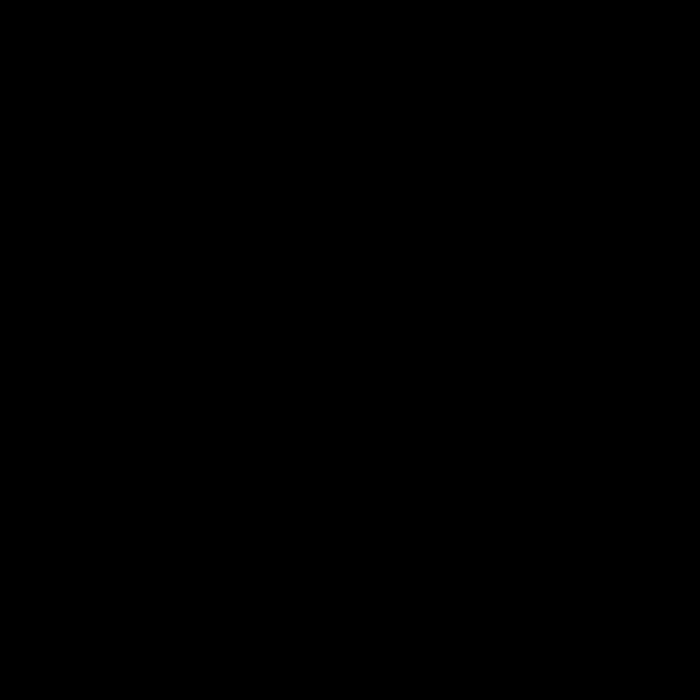

In [104]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')


Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. This talk also provides a nice background for datashader. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.


Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

1. Observe the metadata dictionary:

AssessLand:
The Department of Finance calculates the assessed value by multiplying the tax lot’s estimated full market land value, determined as if vacant and unimproved, by a uniform percentage for the property’s tax class.


AssessTot:
The Department of Finance calculates the assessed value by multiplying the tax lot’s estimated full market value by a uniform percentage for the property’s tax class.
Property value is assessed as of January 5th. If a site is not completed by April 14th the assessed building value is 0 and the Building Class reverts to Vacant.


calculate the assessStruction tax uses total assess tax minus assess land tax. Here to break down the AssessLand and AssessStruct into 3 categories used on the percentile() function. 

In [99]:
ny['AssessStruct'] = ny['AssessTot'] - ny['AssessLand']

al33 = np.percentile(ny['AssessLand'].values, 33)
al66 = np.percentile(ny['AssessLand'].values, 66)
as33 = np.percentile(ny['AssessStruct'].values, 33)
as66 = np.percentile(ny['AssessStruct'].values, 66)

ny['AssessLand3tile'] = ny['AssessLand'].apply(lambda x: 1 if x < al33 else 2 if x < al66 else 3)
ny['AssessStruct3tile'] = ny['AssessStruct'].apply(lambda x: 1 if x < as33 else 2 if x < as66 else 3)

ny['AssessAll3tile'] = ny['AssessLand3tile'].apply(str) + ny['AssessStruct3tile'].apply(str) + 'c'

ny['AssessAll3tile'] = pd.Categorical(ny['AssessAll3tile'])
    
color_key = {
    '11c': '#e8e8e8',
    '12c': '#b0d5df',
    '13c': '#64acbe',
    '21c': '#e4acac',
    '22c': '#ad9ea5',
    '23c': '#627f8c',
    '31c': '#c85a5a',
    '32c': '#985356',
    '33c': '#574249'
}

# greener is Assessed Land, redder is Assessed Total, Maroon is both,

In [119]:
NewYorkCity = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('AssessAll3tile'))
view = tf.shade(agg, color_key = color_key)
export(tf.spread(view, px=1), 'bivariate')

ValueError: zero-size array to reduction operation minimum which has no identity